# Example 3: Magnetic parameters at single grid cell

Once we have calculated the wavelet scalogram of magnetic anomaly data, we are ready to estimate the parameters of the magnetic layer. We will explore this step-by-step again, starting with the estimation of magnetic parameters at a single grid cell.

Let's start again by loading the magnetic anomaly data into a `MagGrid` object and deal with outliers, which is then inserted into a `Project` object. 

In [1]:
import numpy as np
import pandas as pd
from platecurie import MagGrid, Project

xmin, xmax, ymin, ymax, zmin, zmax, dx, dy, nx, ny = \
pd.read_csv('../data/Mag_NWCAN.xyz', sep='\t', nrows=0).columns[1:].values.astype(float)
nx = int(nx); ny = int(ny)

magdata = pd.read_csv('../data/Mag_NWCAN.xyz', sep='\t', \
    skiprows=1, names=['x', 'y', 'z'])['z'].values.reshape(ny,nx)[::-1]
seddata = pd.read_csv('../data/Sed_NWCAN.xyz', sep='\t', \
    skiprows=1, names=['x', 'y', 'z'])['z'].values.reshape(ny,nx)[::-1]

magdata[magdata<-750] = np.nan
magdata[magdata>1000] = np.nan

# Load the data into a MagGrid object
mag = MagGrid(magdata, dx, dy)

# Generate a mask
mask = (magdata==0)

# Load the grid into a Project object
project = Project(grids=[mag])

grid contains NaN values. Performing interpolation...


At this point we still haven't calculated the wavelet scalogram. This is not needed to initialize a `Project` object. However, to continue with the estimation, we *absolutely need* to initialize the project using the method `init()`:

In [2]:
project.init()

Wavelet scalogram 
Initialization: success


You will notice that initialization triggers the calculation of the wavelet transform and scalogram, if these haven't been performed before. 

<div class="alert alert-block alert-info">
<b>Note:</b> A Project object absolutely requires at least one and only one MagGrid object. Otherwise an Exception is raised and the code stops.
</div>

We can explore the content of the initialized `Project` object:

In [3]:
project.__dict__.keys()

dict_keys(['grids', 'mask', 'initialized', 'inverse', 'zt', 'szt', 'wl_sg', 'ewl_sg', 'k', 'ns', 'nx', 'ny', 'dx', 'dy'])

You notice that the project contains new attribute `zt`, which is one of the parameters of the magnetic layer model. Also, during initialization the `inverse` method is set to `L2`:

In [4]:
print(project.zt)
print(project.inverse)

None
L2


By default the `zt` attribute is set to `None`, which implies that the softwares will try to estimate it during the inversion. See later for an example describing how to set a prior value of `zt` in the estimation. 

The default value of the attribute `inverse` (`L2`) implies that by default the software will use a non-linear least-squares method to estimate the magnetic parameters. The two available options are `'L2'` and `'bayes'`, the latter based on a probabilistic estimation method based on bayesian inference. Note that you can initialize a `Project` with a `bayes` inverse method by typing `project(inverse='bayes')`, or you could decide to change it after initialization by typing `project.inverse='bayes'`. A couple of things to note:

<div class="alert alert-block alert-info">
<b>Note 1:</b> The two methods should give very similar results. Differences arise mainly because the 'bayes' approach draws a finite number of samples from the posterior distribution, and equality is achieved only for infinite sampling of the posterior and for the maximum a posteriori (MAP) estimate (because the mean estimate of the posterior can be biased if there is more than one mode). 
</div>

<div class="alert alert-block alert-info">
<b>Note 2:</b> The 'L2' approach is <b>MUCH</b> faster than the 'bayes' approach. However, the 'bayes' approach provides useful statistics for the inference step. 
</div>

Let's examine the estimation of the magnetic parameters using the default `'L2'` approach, by only specifying the cell location (tuple):

           mean         std      chi2
A      3.928389    6.002066  0.493968
zt     1.364610    3.646125  0.493968
dz    38.765261  163.119846  0.493968
beta   2.922877    2.769238  0.493968


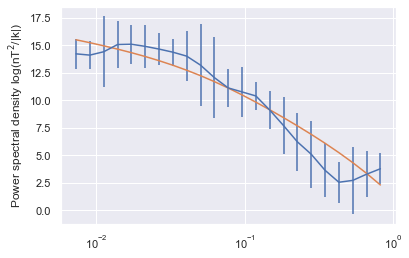

In [5]:
cell = (500, 300)

# Perform estimation
project.estimate_cell(cell)

# Print summary
print(project.summary)

# Plot observed and predicted (best-fit) functions:
project.plot_functions()

Now do the same using the `'bayes'` approach

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [zt]
>Slice: [beta]
>Slice: [dz]
>Slice: [A]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1935.33draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/pascalaudet/anaconda3/envs/curie/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -5.6394e+13: 100%|██████████| 68/68 [00:00<00:00, 4423.62it/s]  
/Users/pascalaudet/anaconda3/envs/curie/lib/python3.7/site-packages/pymc3/stats.py:991: Futu

           mean         sd  mc_error    hpd_2.5   hpd_97.5       n_eff  \
A      4.273157   1.544622  0.130407   1.669664   7.481343   69.771086   
dz    31.583605  11.493367  0.608595  11.852752  49.993694  246.240459   
beta   2.945031   0.475361  0.039747   2.010138   3.832943   63.856860   
zt     1.782979   1.185890  0.087739   0.000308   4.040877   96.525782   

          Rhat  
A     1.014295  
dz    1.004603  
beta  1.018393  
zt    1.009789  


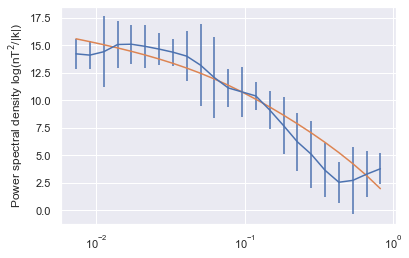

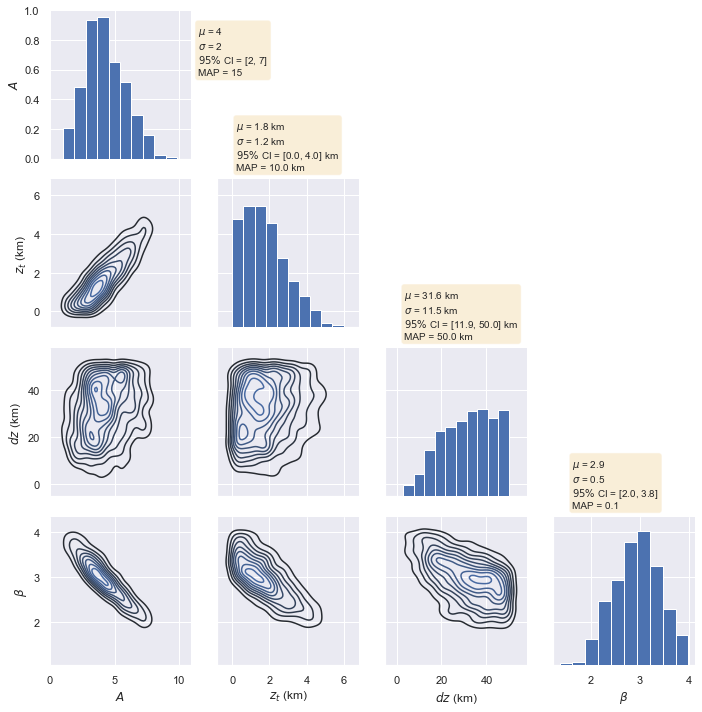

In [6]:
# Switch inverse attribute
project.inverse = 'bayes'

# Perform estimation
project.estimate_cell(cell)

# Print summary
print(project.summary)

# Plot observed and predicted (best-fit) functions using the mean estimate:
project.plot_functions(est='mean')

# Plot stats for estimate
project.plot_stats()

In the background, the method has inverted the local wavelet scalogram (power-spectral density, or PSD) function to estimate the magnetic parameters. Note that it is possible to fix the value of the parameter `beta`, which corresponds to the power-law exponent of fractal magnetization. This value is normally between `0` and `4`. Based on the previous example, let's set it to `3`:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [zt]
>Slice: [dz]
>Slice: [A]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2798.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
/Users/pascalaudet/anaconda3/envs/curie/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -5.6394e+13: 100%|██████████| 46/46 [00:00<00:00, 4794.56it/s]  
/Users/pascalaudet/anaconda3/envs/curie/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-

         mean         sd  mc_error    hpd_2.5   hpd_97.5       n_eff      Rhat
A    3.996245   0.684855  0.038740   2.774843   5.351959  288.166473  1.002255
dz  32.263701  10.718505  0.547584  13.980718  49.973337  333.391871  1.001142
zt   1.528165   0.826632  0.036096   0.025406   2.994065  464.073269  1.000213


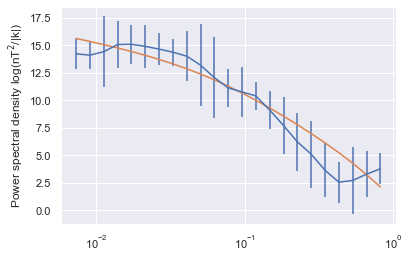

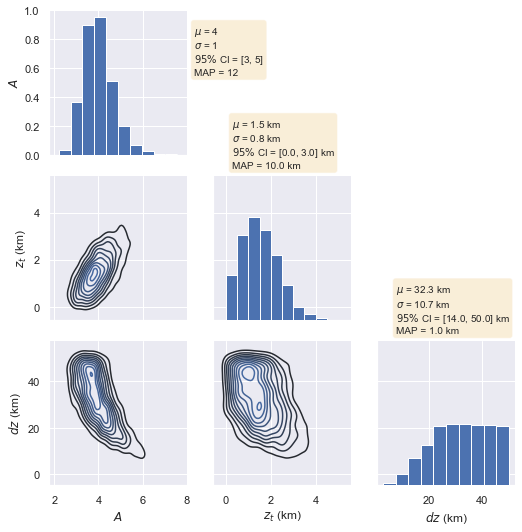

In [7]:
project.estimate_cell(cell, fix_beta=3.)

# Print summary
print(project.summary)

# Plot observed and predicted (best-fit) functions using the mean estimate:
project.plot_functions(est='mean')

# Plot stats for estimate
project.plot_stats()

The results are not very different, but the uncertainty on `dz` is somewhat lower (though it is still not very well estimated - the distribution is close to the prior uniform distribution). We can also try to set a prior value for `zt`, which will be the goal of Example 4.